In my [previous blog post](https://www.carlos-toruno.com/blog/streamlit/01-intro/), I showed how to program a choropleth map generator using Streamlit. While doing this, I encountered an issue I had never experienced before. More specifically, how to explode geometries. As you might know, there is a huge international debate about Taiwan being a sovereign country. As a result, many "*official*" datasets containing world boundaries would usually include the island of Taiwan as part of China. The big question that relates to this blog post is, how can we split the boundaries between these two territories? Therefore, in this blog post, I will be explaining to you how I solved this issue using the [GeoPandas library](https://geopandas.org/en/stable/) in Python.

<img src="featured.png" width="100%"/>

## A little bit of context
Since the approval of the [resolution 2758(XXVI)](https://undocs.org/en/A/RES/2758(XXVI)) by the United Nations back in 1971, Taiwan has been excluded from many international circles. Taiwan does not have a seat in the United Nations since their representatives were expelled after the approval of this resolution. At the same time, if you search for Taiwan in the [list of countries and economies](https://data.worldbank.org/country) in the World Bank Data portal, you won't find it.

To be honest, I have been reading a lot about this issue and I have found it to be very interesting. For example, the UN resolution states that "(...) the representatives of the Government of the People's Republic of China are the only lawful representatives of China", not that Taiwan is not a country. Which is a very important highlight if you want to use this resolution in favor of the "One-China policy". This has opened a very interesting diplomatic strategy for the Government of Taipei in trying to highlight the difference between China and Taiwan. If you would like to read about this in more depth, I would suggest you to read [this article](https://verfassungsblog.de/taiwan-and-the-myth-of-un-general-assembly-resolution-2758/) by prof. Chien-Huei Wu. This approach is even mmore interesting when you take a look at the data from public opinion polls. According to the National Chengchi University, less than 20% of the population living in the island considered themselves Taiwanese, while more than 70% considered themselves chinese or both. Thirty years later, almost 65% of the population considered themselves taiwanese and not chinese (check [this article](https://www.bbc.com/news/world-asia-china-59900139) by the BBC for more interesting data).

Now, as I stated in my previous [previous blog post](https://www.carlos-toruno.com/blog/streamlit/01-intro/), I intended to use the [World Bank Official Boundaries Data](https://datacatalog.worldbank.org/search/dataset/0038272/World-Bank-Official-Boundaries). Let's load the data, subset China and see how it looks in a map.

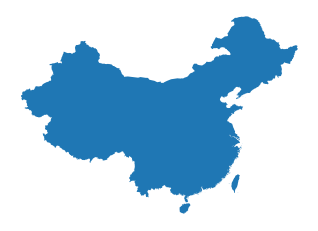

In [8]:
import geopandas as gpd

# Loading World Bank Official Boundaries
raw_boundaries  = (gpd.read_file("WB_countries_Admin0.geojson"))

# Subsetting China -> Code "CHN"
china    = raw_boundaries.loc[raw_boundaries["WB_A3"] == "CHN"]

# Plotting the geometries
china.plot().set_axis_off()

I hope your geography knowledge is outstanding, but in case you are a little bit lost...

Do you see that small island in the southeast, that's Taiwan! And it should not be displayed in this map because we were ONLY subsetting the geometries that belong to country code CHN, in other words, the People's Republic of China. Now, how do we solve this?

## Possible solutions

The most logical solution that many of you would propose is to use a subnational boundaries or a ADM-1 level data. Saadly, the World Bank does not supply an official licensed ADM-1 data for subnational boundaries. Then, why not use any other source like our beloved [geoBoundaries](https://www.geoboundaries.org/)? As it happens, I need an official source for the map generator app, preferrably from the United Nations or the World Bank.

Many of you would say, well, this issue can be quickly solved using a some clicks aand options in ArcGIS or QGIS. However, I refuse to do this outside Python. So, I just asked Google about how could I split a geometry and I quickly found something called "*exploding*".  

In GIS, exploding a geometry means to break a feature into its individual parts. This means that, if you have a multipolygon, you would end up with multiple individual and differentiable polygons. But if you have a polygon, you would end up  with multiple individual and differentiable lines, and so on. The most important part, is that each of these splitted parts would be a different feature by itself. The Geopandas library comes with aa native API function that allows us to do this.

## Using GeoPandas to explode geometries

Given that country boundaries are multipolygon features, if we were to explode China, we should end up with a geopandas data frame containing the continental part of China and all its islands, which are indeed a lot. Let's see what happens.

First, let's take a look at our current subset for China:

In [29]:
china[["TYPE", "WB_A3", "NAME_EN", "geometry"]]

,TYPE,WB_A3,NAME_EN,geometry
8,Country,CHN,People's Republic of China,"MULTIPOLYGON (((110.68507 20.15331, 110.67791 ..."


As we can observe, we currently have a single row geo dataframe and its geometry states that it is a multipolygon. That means that if we explode this subset, we should en up with a geo data frame listing all of its polygons. Let's see if that's the case:

In [28]:
## Exploding China's geometry
china_ex = (china[["TYPE", "WB_A3", "CONTINENT", 
                   "REGION_UN", "SUBREGION", "REGION_WB", 
                   "NAME_EN", "WB_NAME", "WB_REGION", 
                   "geometry"]]
            .explode(index_parts = True)
            .reset_index(drop = True))

## How does the new geo-data-frame look like?
china_ex

,TYPE,WB_A3,CONTINENT,REGION_UN,SUBREGION,REGION_WB,NAME_EN,WB_NAME,WB_REGION,geometry
0,Country,CHN,Asia,Asia,Eastern Asia,East Asia & Pacific,People's Republic of China,China,EAP,"POLYGON ((110.68507 20.15331, 110.67791 20.163..."
1,Country,CHN,Asia,Asia,Eastern Asia,East Asia & Pacific,People's Republic of China,China,EAP,"POLYGON ((110.44264 20.66352, 110.43702 20.667..."
2,Country,CHN,Asia,Asia,Eastern Asia,East Asia & Pacific,People's Republic of China,China,EAP,"POLYGON ((110.60955 20.89728, 110.62452 20.915..."
3,Country,CHN,Asia,Asia,Eastern Asia,East Asia & Pacific,People's Republic of China,China,EAP,"POLYGON ((109.10524 21.02448, 109.11256 21.027..."
4,Country,CHN,Asia,Asia,Eastern Asia,East Asia & Pacific,People's Republic of China,China,EAP,"POLYGON ((110.38982 21.09589, 110.37135 21.080..."
...,...,...,...,...,...,...,...,...,...,...
66,Country,CHN,Asia,Asia,Eastern Asia,East Asia & Pacific,People's Republic of China,China,EAP,"POLYGON ((122.74195 39.23607, 122.71860 39.241..."
67,Country,CHN,Asia,Asia,Eastern Asia,East Asia & Pacific,People's Republic of China,China,EAP,"POLYGON ((122.68442 39.26219, 122.66326 39.272..."
68,Country,CHN,Asia,Asia,Eastern Asia,East Asia & Pacific,People's Republic of China,China,EAP,"POLYGON ((121.35255 39.48241, 121.34059 39.481..."
69,Country,CHN,Asia,Asia,Eastern Asia,East Asia & Pacific,People's Republic of China,China,EAP,"POLYGON ((123.02996 39.50788, 123.04005 39.529..."


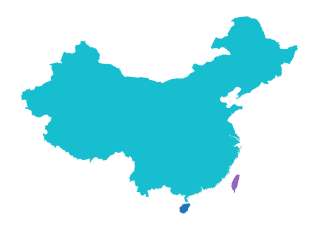

In [33]:
china_ex.plot(column="geometry").set_axis_off()

As we can see, we now have a geo data frame with 71 rows. However, there is no way for us to know which feature is what. If we plot the data and differentiate by different features, we are only able to distinguish the three larger ones: continental China, the island of Taiwan, and the island of Hainan, respectively. Therefore, we need to highlight the second larger polygon. We can do this by estimating the area and subsetting

In [52]:
# Create a new column to store the area values
china_ex["area_m2"] = (china_ex
                       .to_crs("ESRI:54003")
                       .geometry
                       .area)

## Sorting values
china_exsort = china_ex.sort_values(by = "area_m2", 
                                    ascending = False)

## Which row index represents Taiwan?
china_exsort.iloc[1:2]

,TYPE,WB_A3,CONTINENT,REGION_UN,SUBREGION,REGION_WB,NAME_EN,WB_NAME,WB_REGION,geometry,area_m2
31,Country,CHN,Asia,Asia,Eastern Asia,East Asia & Pacific,People's Republic of China,China,EAP,"POLYGON ((121.63600 25.22281, 121.59791 25.271...",4.153658e+10


As we can observe, Taiwan is the feature with row index 31 in the data frame. We could confirm this visually by plotting this feature alone. Again, I'm assuming that you have outstanding geography notions. But if you don't, here you have the mapped feature that we got and a google maps image of Taiwan. If they look alike, probably we are doing things right.

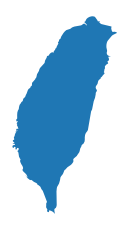

In [54]:
china_exsort.iloc[1:2].plot().set_axis_off()

<img src="taiwan_google.png" width="40%"/>

We have been succesfully been able to identify Taiwan, what do we do now? Well, we basically need to rejoin all the other islands back to China, remove the China/Taiwan feature from our boundaries data and add the exploded data with China and Taiwan as sepaarate features. Sounds comple, right? Well, it's actually quite straightforward. Let's go step by step.

First, we first need to manually input Taiwan's counntry data as follows:

In [56]:
# Manually inputting Taiwan's info
china_ex.at[31, 'WB_A3']   = "TWN"
china_ex.at[31, 'NAME_EN'] = "Taiwan"
china_ex.at[31, 'WB_NAME'] = "Taiwan"

Once we have inputed that data, we can dissolve the geometries to form a simplified data frame. If you are wondering what is to dissolve a geometry, it's bassically the opposite of exploding. We want to aggregate all those islands to the same feature as continental China. Except Taiwan, of course.

In [58]:
# Disolving exploded geopandas for China
china_taiwan = (china_ex
                .dissolve(by      = "WB_A3",
                          aggfunc = "first")).reset_index()

china_taiwan

,WB_A3,geometry,TYPE,CONTINENT,REGION_UN,SUBREGION,REGION_WB,NAME_EN,WB_NAME,WB_REGION,area_m2
0,CHN,"MULTIPOLYGON (((110.86988 19.99702, 110.89015 ...",Country,Asia,Asia,Eastern Asia,East Asia & Pacific,People's Republic of China,China,EAP,3.727520e+10
1,TWN,"POLYGON ((121.63600 25.22281, 121.59791 25.271...",Country,Asia,Asia,Eastern Asia,East Asia & Pacific,Taiwan,Taiwan,EAP,4.153658e+10


Once that we have China and Taiwan as different features, we proceed to append this new data to our world boundaries. However, don't forget to drop the previous China feature!!!

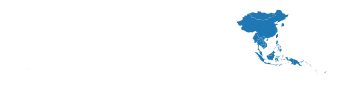

In [77]:
import pandas as pd

# Appending china+taiwan geopandas to raw_boundaries
raw_boundaries = (pd.concat([raw_boundaries.loc[raw_boundaries["WB_A3"] != "CHN"],
                             china_taiwan],
                             ignore_index = True))

raw_boundaries[raw_boundaries["WB_REGION"] == "EAP"].plot().set_axis_off()

This way, we have been able to split China and Taiwan as separate features without having to change our source data and just with a few lines of code.